In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

import os
import csv

import torch
import random
import numpy as np

import socket
import datetime

from dataclasses import dataclass

import torch
import torchvision
import torchvision.transforms as transforms

/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
arch = 'ResNet152'
num_images = 1
trained_model = True

PIN_MEMORY = True
NON_BLOCKING = False
BENCHMARK = True
MULTITHREAD_DATAPROCESSING = 4


cifar10_mean = [0.4914672374725342, 0.4822617471218109, 0.4467701315879822]
cifar10_std = [0.24703224003314972, 0.24348513782024384, 0.26158785820007324]
cifar100_mean = [0.5071598291397095, 0.4866936206817627, 0.44120192527770996]
cifar100_std = [0.2673342823982239, 0.2564384639263153, 0.2761504650115967]
mnist_mean = (0.13066373765468597,)
mnist_std = (0.30810782313346863,)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

In [3]:
def system_startup(args=None, defs=None):
    """Print useful system information."""
    # Choose GPU device and print status information:
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    setup = dict(device=device, dtype=torch.float)  # non_blocking=NON_BLOCKING
    print('Currently evaluating -------------------------------:')
    print(datetime.datetime.now().strftime("%A, %d. %B %Y %I:%M%p"))
    print(f'CPUs: {torch.get_num_threads()}, GPUs: {torch.cuda.device_count()} on {socket.gethostname()}.')
    if args is not None:
        print(args)
    if defs is not None:
        print(repr(defs))
    if torch.cuda.is_available():
        print(f'GPU : {torch.cuda.get_device_name(device=device)}')
    return setup

def training_strategy(strategy, lr=None, epochs=None, dryrun=False):
    """Parse training strategy."""
    if strategy == 'conservative':
        defs = ConservativeStrategy(lr, epochs, dryrun)
    elif strategy == 'adam':
        defs = AdamStrategy(lr, epochs, dryrun)
    else:
        raise ValueError('Unknown training strategy.')
    return defs

@dataclass
class Strategy:
    """Default usual parameters, not intended for parsing."""

    epochs : int
    batch_size : int
    optimizer : str
    lr : float
    scheduler : str
    weight_decay : float
    validate : int
    warmup: bool
    dryrun : bool
    dropout : float
    augmentations : bool

    def __init__(self, lr=None, epochs=None, dryrun=False):
        """Defaulted parameters. Apply overwrites from args."""
        if epochs is not None:
            self.epochs = epochs
        if lr is not None:
            self.lr = lr
        if dryrun:
            self.dryrun = dryrun
        self.validate = 10

@dataclass
class ConservativeStrategy(Strategy):
    """Default usual parameters, defines a config object."""

    def __init__(self, lr=None, epochs=None, dryrun=False):
        """Initialize training hyperparameters."""
        self.lr = 0.1
        self.epochs = 120
        self.batch_size = 128
        self.optimizer = 'SGD'
        self.scheduler = 'linear'
        self.warmup = False
        self.weight_decay : float = 5e-4
        self.dropout = 0.0
        self.augmentations = True
        self.dryrun = False
        super().__init__(lr=None, epochs=None, dryrun=False)

@dataclass
class AdamStrategy(Strategy):
    """Start slowly. Use a tame Adam."""

    def __init__(self, lr=None, epochs=None, dryrun=False):
        """Initialize training hyperparameters."""
        self.lr = 1e-3 / 10
        self.epochs = 120
        self.batch_size = 32
        self.optimizer = 'AdamW'
        self.scheduler = 'linear'
        self.warmup = True
        self.weight_decay : float = 5e-4
        self.dropout = 0.0
        self.augmentations = True
        self.dryrun = False
        super().__init__(lr=None, epochs=None, dryrun=False)
        
def construct_dataloaders(dataset, defs, data_path='~/data', shuffle=True, normalize=True):
    """Return a dataloader with given dataset and augmentation, normalize data?."""
    path = os.path.expanduser(data_path)

    if dataset == 'CIFAR10':
        trainset, validset = _build_cifar10(path, defs.augmentations, normalize)
        loss_fn = Classification()
    elif dataset == 'CIFAR100':
        trainset, validset = _build_cifar100(path, defs.augmentations, normalize)
        loss_fn = Classification()
    elif dataset == 'MNIST':
        trainset, validset = _build_mnist(path, defs.augmentations, normalize)
        loss_fn = Classification()
    elif dataset == 'MNIST_GRAY':
        trainset, validset = _build_mnist_gray(path, defs.augmentations, normalize)
        loss_fn = Classification()
    elif dataset == 'ImageNet':
        trainset, validset = _build_imagenet(path, defs.augmentations, normalize)
        loss_fn = Classification()

    if MULTITHREAD_DATAPROCESSING:
        num_workers = min(torch.get_num_threads(), MULTITHREAD_DATAPROCESSING) if torch.get_num_threads() > 1 else 0
    else:
        num_workers = 0

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=min(defs.batch_size, len(trainset)),
                                            shuffle=shuffle, drop_last=True, num_workers=num_workers, pin_memory=PIN_MEMORY)
    validloader = torch.utils.data.DataLoader(validset, batch_size=min(defs.batch_size, len(trainset)),
                                            shuffle=False, drop_last=False, num_workers=num_workers, pin_memory=PIN_MEMORY)

    return loss_fn, trainloader, validloader

def _build_cifar10(data_path, augmentations=True, normalize=True):
    """Define CIFAR-10 with everything considered."""
    # Load data
    trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transforms.ToTensor())
    validset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transforms.ToTensor())

    if cifar10_mean is None:
        data_mean, data_std = _get_meanstd(trainset)
    else:
        data_mean, data_std = cifar10_mean, cifar10_std

    # Organize preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std) if normalize else transforms.Lambda(lambda x: x)])
    if augmentations:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transform])
        trainset.transform = transform_train
    else:
        trainset.transform = transform
    validset.transform = transform

    return trainset, validset

def _build_cifar100(data_path, augmentations=True, normalize=True):
    """Define CIFAR-100 with everything considered."""
    # Load data
    trainset = torchvision.datasets.CIFAR100(root=data_path, train=True, download=True, transform=transforms.ToTensor())
    validset = torchvision.datasets.CIFAR100(root=data_path, train=False, download=True, transform=transforms.ToTensor())

    if cifar100_mean is None:
        data_mean, data_std = _get_meanstd(trainset)
    else:
        data_mean, data_std = cifar100_mean, cifar100_std

    # Organize preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std) if normalize else transforms.Lambda(lambda x: x)])
    if augmentations:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transform])
        trainset.transform = transform_train
    else:
        trainset.transform = transform
    validset.transform = transform

    return trainset, validset

def _build_mnist(data_path, augmentations=True, normalize=True):
    """Define MNIST with everything considered."""
    # Load data
    trainset = torchvision.datasets.MNIST(root=data_path, train=True, download=True, transform=transforms.ToTensor())
    validset = torchvision.datasets.MNIST(root=data_path, train=False, download=True, transform=transforms.ToTensor())

    if mnist_mean is None:
        cc = torch.cat([trainset[i][0].reshape(-1) for i in range(len(trainset))], dim=0)
        data_mean = (torch.mean(cc, dim=0).item(),)
        data_std = (torch.std(cc, dim=0).item(),)
    else:
        data_mean, data_std = mnist_mean, mnist_std

    # Organize preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std) if normalize else transforms.Lambda(lambda x: x)])
    if augmentations:
        transform_train = transforms.Compose([
            transforms.RandomCrop(28, padding=4),
            transforms.RandomHorizontalFlip(),
            transform])
        trainset.transform = transform_train
    else:
        trainset.transform = transform
    validset.transform = transform

    return trainset, validset

def _build_mnist_gray(data_path, augmentations=True, normalize=True):
    """Define MNIST with everything considered."""
    # Load data
    trainset = torchvision.datasets.MNIST(root=data_path, train=True, download=True, transform=transforms.ToTensor())
    validset = torchvision.datasets.MNIST(root=data_path, train=False, download=True, transform=transforms.ToTensor())

    if mnist_mean is None:
        cc = torch.cat([trainset[i][0].reshape(-1) for i in range(len(trainset))], dim=0)
        data_mean = (torch.mean(cc, dim=0).item(),)
        data_std = (torch.std(cc, dim=0).item(),)
    else:
        data_mean, data_std = mnist_mean, mnist_std

    # Organize preprocessing
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std) if normalize else transforms.Lambda(lambda x: x)])
    if augmentations:
        transform_train = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomCrop(28, padding=4),
            transforms.RandomHorizontalFlip(),
            transform])
        trainset.transform = transform_train
    else:
        trainset.transform = transform
    validset.transform = transform

    return trainset, validset

def _build_imagenet(data_path, augmentations=True, normalize=True):
    """Define ImageNet with everything considered."""
    # Load data
    trainset = torchvision.datasets.ImageNet(root=data_path, split='train', transform=transforms.ToTensor())
    validset = torchvision.datasets.ImageNet(root=data_path, split='val', transform=transforms.ToTensor())

    if imagenet_mean is None:
        data_mean, data_std = _get_meanstd(trainset)
    else:
        data_mean, data_std = imagenet_mean, imagenet_std

    # Organize preprocessing
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std) if normalize else transforms.Lambda(lambda x : x)])
    if augmentations:
        transform_train = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(data_mean, data_std) if normalize else transforms.Lambda(lambda x : x)])
        trainset.transform = transform_train
    else:
        trainset.transform = transform
    validset.transform = transform

    return trainset, validset

def _get_meanstd(dataset):
    cc = torch.cat([trainset[i][0].reshape(3, -1) for i in range(len(trainset))], dim=1)
    data_mean = torch.mean(cc, dim=1).tolist()
    data_std = torch.std(cc, dim=1).tolist()
    return data_mean, data_std

class Loss:
    """Abstract class, containing necessary methods.

    Abstract class to collect information about the 'higher-level' loss function, used to train an energy-based model
    containing the evaluation of the loss function, its gradients w.r.t. to first and second argument and evaluations
    of the actual metric that is targeted.

    """

    def __init__(self):
        """Init."""
        pass

    def __call__(self, reference, argmin):
        """Return l(x, y)."""
        raise NotImplementedError()
        return value, name, format

    def metric(self, reference, argmin):
        """The actually sought metric."""
        raise NotImplementedError()
        return value, name, format

class PSNR(Loss):
    """A classical MSE target.

    The minimized criterion is MSE Loss, the actual metric is average PSNR.
    """

    def __init__(self):
        """Init with torch MSE."""
        self.loss_fn = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

    def __call__(self, x=None, y=None):
        """Return l(x, y)."""
        name = 'MSE'
        format = '.6f'
        if x is None:
            return name, format
        else:
            value = 0.5 * self.loss_fn(x, y)
            return value, name, format

    def metric(self, x=None, y=None):
        """The actually sought metric."""
        name = 'avg PSNR'
        format = '.3f'
        if x is None:
            return name, format
        else:
            value = self.psnr_compute(x, y)
            return value, name, format

    @staticmethod
    def psnr_compute(img_batch, ref_batch, batched=False, factor=1.0):
        """Standard PSNR."""
        def get_psnr(img_in, img_ref):
            mse = ((img_in - img_ref)**2).mean()
            if mse > 0 and torch.isfinite(mse):
                return (10 * torch.log10(factor**2 / mse)).item()
            elif not torch.isfinite(mse):
                return float('nan')
            else:
                return float('inf')

        if batched:
            psnr = get_psnr(img_batch.detach(), ref_batch)
        else:
            [B, C, m, n] = img_batch.shape
            psnrs = []
            for sample in range(B):
                psnrs.append(get_psnr(img_batch.detach()[sample, :, :, :], ref_batch[sample, :, :, :]))
            psnr = np.mean(psnrs)

        return psnr
    
class Classification(Loss):
    """A classical NLL loss for classification. Evaluation has the softmax baked in.

    The minimized criterion is cross entropy, the actual metric is total accuracy.
    """

    def __init__(self):
        """Init with torch MSE."""
        self.loss_fn = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100,
                                                reduce=None, reduction='mean')

    def __call__(self, x=None, y=None):
        """Return l(x, y)."""
        name = 'CrossEntropy'
        format = '1.5f'
        if x is None:
            return name, format
        else:
            value = self.loss_fn(x, y)
            return value, name, format

    def metric(self, x=None, y=None):
        """The actually sought metric."""
        name = 'Accuracy'
        format = '6.2%'
        if x is None:
            return name, format
        else:
            value = (x.data.argmax(dim=1) == y).sum().float() / y.shape[0]
            return value.detach(), name, format

In [4]:
setup = system_startup()
defs = training_strategy('conservative')
loss_fn, trainloader, validloader =  construct_dataloaders('CIFAR10', defs)

Currently evaluating -------------------------------:
Sunday, 19. January 2025 11:48PM
CPUs: 24, GPUs: 1 on stair-Alienware-Aurora-R16.
GPU : NVIDIA GeForce RTX 4090
Files already downloaded and verified
Files already downloaded and verified


In [5]:
import torch.nn as nn
from torchvision.models.resnet import Bottleneck
from collections import OrderedDict

In [6]:
def set_random_seed(seed=233):
    """233 = 144 + 89 is my favorite number."""
    torch.manual_seed(seed + 1)
    torch.cuda.manual_seed(seed + 2)
    torch.cuda.manual_seed_all(seed + 3)
    np.random.seed(seed + 4)
    torch.cuda.manual_seed_all(seed + 5)
    random.seed(seed + 6)

def construct_model(model, num_classes=10, seed=None, num_channels=3, modelkey=None):
    """Return various models."""
    if modelkey is None:
        if seed is None:
            model_init_seed = np.random.randint(0, 2**32 - 10)
        else:
            model_init_seed = seed
    else:
        model_init_seed = modelkey
    set_random_seed(model_init_seed)

    if model in ['ConvNet', 'ConvNet64']:
        model = ConvNet(width=64, num_channels=num_channels, num_classes=num_classes)
    elif model == 'ConvNet8':
        model = ConvNet(width=64, num_channels=num_channels, num_classes=num_classes)
    elif model == 'ConvNet16':
        model = ConvNet(width=64, num_channels=num_channels, num_classes=num_classes)
    elif model == 'ConvNet32':
        model = ConvNet(width=64, num_channels=num_channels, num_classes=num_classes)
    elif model == 'BeyondInferringMNIST':
        model = torch.nn.Sequential(OrderedDict([
            ('conv1', torch.nn.Conv2d(1, 32, 3, stride=2, padding=1)),
            ('relu0', torch.nn.LeakyReLU()),
            ('conv2', torch.nn.Conv2d(32, 64, 3, stride=1, padding=1)),
            ('relu1', torch.nn.LeakyReLU()),
            ('conv3', torch.nn.Conv2d(64, 128, 3, stride=2, padding=1)),
            ('relu2', torch.nn.LeakyReLU()),
            ('conv4', torch.nn.Conv2d(128, 256, 3, stride=1, padding=1)),
            ('relu3', torch.nn.LeakyReLU()),
            ('flatt', torch.nn.Flatten()),
            ('linear0', torch.nn.Linear(12544, 12544)),
            ('relu4', torch.nn.LeakyReLU()),
            ('linear1', torch.nn.Linear(12544, 10)),
            ('softmax', torch.nn.Softmax(dim=1))
        ]))
    elif model == 'BeyondInferringCifar':
        model = torch.nn.Sequential(OrderedDict([
            ('conv1', torch.nn.Conv2d(3, 32, 3, stride=2, padding=1)),
            ('relu0', torch.nn.LeakyReLU()),
            ('conv2', torch.nn.Conv2d(32, 64, 3, stride=1, padding=1)),
            ('relu1', torch.nn.LeakyReLU()),
            ('conv3', torch.nn.Conv2d(64, 128, 3, stride=2, padding=1)),
            ('relu2', torch.nn.LeakyReLU()),
            ('conv4', torch.nn.Conv2d(128, 256, 3, stride=1, padding=1)),
            ('relu3', torch.nn.LeakyReLU()),
            ('flatt', torch.nn.Flatten()),
            ('linear0', torch.nn.Linear(12544, 12544)),
            ('relu4', torch.nn.LeakyReLU()),
            ('linear1', torch.nn.Linear(12544, 10)),
            ('softmax', torch.nn.Softmax(dim=1))
        ]))
    elif model == 'MLP':
        width = 1024
        model = torch.nn.Sequential(OrderedDict([
            ('flatten', torch.nn.Flatten()),
            ('linear0', torch.nn.Linear(3072, width)),
            ('relu0', torch.nn.ReLU()),
            ('linear1', torch.nn.Linear(width, width)),
            ('relu1', torch.nn.ReLU()),
            ('linear2', torch.nn.Linear(width, width)),
            ('relu2', torch.nn.ReLU()),
            ('linear3', torch.nn.Linear(width, num_classes))]))
    elif model == 'TwoLP':
        width = 2048
        model = torch.nn.Sequential(OrderedDict([
            ('flatten', torch.nn.Flatten()),
            ('linear0', torch.nn.Linear(3072, width)),
            ('relu0', torch.nn.ReLU()),
            ('linear3', torch.nn.Linear(width, num_classes))]))
    elif model == 'ResNet20':
        model = ResNet(torchvision.models.resnet.BasicBlock, [3, 3, 3], num_classes=num_classes, base_width=16)
    elif model == 'ResNet20-nostride':
        model = ResNet(torchvision.models.resnet.BasicBlock, [3, 3, 3], num_classes=num_classes, base_width=16,
                    strides=[1, 1, 1, 1])
    elif model == 'ResNet20-10':
        model = ResNet(torchvision.models.resnet.BasicBlock, [3, 3, 3], num_classes=num_classes, base_width=16 * 10)
    elif model == 'ResNet20-4':
        model = ResNet(torchvision.models.resnet.BasicBlock, [3, 3, 3], num_classes=num_classes, base_width=16 * 4)
    elif model == 'ResNet20-4-unpooled':
        model = ResNet(torchvision.models.resnet.BasicBlock, [3, 3, 3], num_classes=num_classes, base_width=16 * 4,
                    pool='max')
    elif model == 'ResNet28-10':
        model = ResNet(torchvision.models.resnet.BasicBlock, [4, 4, 4], num_classes=num_classes, base_width=16 * 10)
    elif model == 'ResNet32':
        model = ResNet(torchvision.models.resnet.BasicBlock, [5, 5, 5], num_classes=num_classes, base_width=16)
    elif model == 'ResNet32-10':
        model = ResNet(torchvision.models.resnet.BasicBlock, [5, 5, 5], num_classes=num_classes, base_width=16 * 10)
    elif model == 'ResNet44':
        model = ResNet(torchvision.models.resnet.BasicBlock, [7, 7, 7], num_classes=num_classes, base_width=16)
    elif model == 'ResNet56':
        model = ResNet(torchvision.models.resnet.BasicBlock, [9, 9, 9], num_classes=num_classes, base_width=16)
    elif model == 'ResNet110':
        model = ResNet(torchvision.models.resnet.BasicBlock, [18, 18, 18], num_classes=num_classes, base_width=16)
    elif model == 'ResNet18':
        model = ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=num_classes, base_width=64)
    elif model == 'ResNet34':
        model = ResNet(torchvision.models.resnet.BasicBlock, [3, 4, 6, 3], num_classes=num_classes, base_width=64)
    elif model == 'ResNet50':
        model = ResNet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], num_classes=num_classes, base_width=64)
    elif model == 'ResNet50-2':
        model = ResNet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], num_classes=num_classes, base_width=64 * 2)
    elif model == 'ResNet101':
        model = ResNet(torchvision.models.resnet.Bottleneck, [3, 4, 23, 3], num_classes=num_classes, base_width=64)
    elif model == 'ResNet152':
        model = ResNet(torchvision.models.resnet.Bottleneck, [3, 8, 36, 3], num_classes=num_classes, base_width=64)
    elif model == 'MobileNet':
        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 1],  # cifar adaptation, cf.https://github.com/kuangliu/pytorch-cifar/blob/master/models/mobilenetv2.py
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
        model = torchvision.models.MobileNetV2(num_classes=num_classes,
                                               inverted_residual_setting=inverted_residual_setting,
                                               width_mult=1.0)
        model.features[0] = torchvision.models.mobilenet.ConvBNReLU(num_channels, 32, stride=1)  # this is fixed to width=1
    elif model == 'MNASNet':
        model = torchvision.models.MNASNet(1.0, num_classes=num_classes, dropout=0.2)
    elif model == 'DenseNet121':
        model = torchvision.models.DenseNet(growth_rate=32, block_config=(6, 12, 24, 16),
                                            num_init_features=64, bn_size=4, drop_rate=0, num_classes=num_classes,
                                            memory_efficient=False)
    elif model == 'DenseNet40':
        model = _DenseNet(_Bottleneck, [6, 6, 6, 0], growth_rate=12, num_classes=num_classes)
    elif model == 'DenseNet40-4':
        model = _DenseNet(_Bottleneck, [6, 6, 6, 0], growth_rate=12 * 4, num_classes=num_classes)
    elif model == 'SRNet3':
        model = SRNet(upscale_factor=3, num_channels=num_channels)
    elif model == 'SRNet1':
        model = SRNet(upscale_factor=1, num_channels=num_channels)
    elif model == 'iRevNet':
        if num_classes <= 100:
            in_shape = [num_channels, 32, 32]  # only for cifar right now
            model = iRevNet(nBlocks=[18, 18, 18], nStrides=[1, 2, 2],
                            nChannels=[16, 64, 256], nClasses=num_classes,
                            init_ds=0, dropout_rate=0.1, affineBN=True,
                            in_shape=in_shape, mult=4)
        else:
            in_shape = [3, 224, 224]  # only for imagenet
            model = iRevNet(nBlocks=[6, 16, 72, 6], nStrides=[2, 2, 2, 2],
                            nChannels=[24, 96, 384, 1536], nClasses=num_classes,
                            init_ds=2, dropout_rate=0.1, affineBN=True,
                            in_shape=in_shape, mult=4)
    elif model == 'LeNetZhu':
        model = LeNetZhu(num_channels=num_channels, num_classes=num_classes)
    else:
        raise NotImplementedError('Model not implemented.')

    print(f'Model initialized with random key {model_init_seed}.')
    return model, model_init_seed

class ResNet(torchvision.models.ResNet):
    """ResNet generalization for CIFAR thingies."""

    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                groups=1, base_width=64, replace_stride_with_dilation=None,
                norm_layer=None, strides=[1, 2, 2, 2], pool='avg'):
        """Initialize as usual. Layers and strides are scriptable."""
        super(torchvision.models.ResNet, self).__init__()  # nn.Module
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer


        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False, False]
        if len(replace_stride_with_dilation) != 4:
            raise ValueError("replace_stride_with_dilation should be None "
                            "or a 4-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups

        self.inplanes = base_width
        self.base_width = 64  # Do this to circumvent BasicBlock errors. The value is not actually used.
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        self.layers = torch.nn.ModuleList()
        width = self.inplanes
        for idx, layer in enumerate(layers):
            self.layers.append(self._make_layer(block, width, layer, stride=strides[idx], dilate=replace_stride_with_dilation[idx]))
            width *= 2

        self.pool = nn.AdaptiveAvgPool2d((1, 1)) if pool == 'avg' else nn.AdaptiveMaxPool2d((1, 1))
        self.fc = nn.Linear(width // 2 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)


    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        for layer in self.layers:
            x = layer(x)

        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


class ConvNet(torch.nn.Module):
    """ConvNetBN."""

    def __init__(self, width=32, num_classes=10, num_channels=3):
        """Init with width and num classes."""
        super().__init__()
        self.model = torch.nn.Sequential(OrderedDict([
            ('conv0', torch.nn.Conv2d(num_channels, 1 * width, kernel_size=3, padding=1)),
            ('bn0', torch.nn.BatchNorm2d(1 * width)),
            ('relu0', torch.nn.ReLU()),

            ('conv1', torch.nn.Conv2d(1 * width, 2 * width, kernel_size=3, padding=1)),
            ('bn1', torch.nn.BatchNorm2d(2 * width)),
            ('relu1', torch.nn.ReLU()),

            ('conv2', torch.nn.Conv2d(2 * width, 2 * width, kernel_size=3, padding=1)),
            ('bn2', torch.nn.BatchNorm2d(2 * width)),
            ('relu2', torch.nn.ReLU()),

            ('conv3', torch.nn.Conv2d(2 * width, 4 * width, kernel_size=3, padding=1)),
            ('bn3', torch.nn.BatchNorm2d(4 * width)),
            ('relu3', torch.nn.ReLU()),

            ('conv4', torch.nn.Conv2d(4 * width, 4 * width, kernel_size=3, padding=1)),
            ('bn4', torch.nn.BatchNorm2d(4 * width)),
            ('relu4', torch.nn.ReLU()),

            ('conv5', torch.nn.Conv2d(4 * width, 4 * width, kernel_size=3, padding=1)),
            ('bn5', torch.nn.BatchNorm2d(4 * width)),
            ('relu5', torch.nn.ReLU()),

            ('pool0', torch.nn.MaxPool2d(3)),

            ('conv6', torch.nn.Conv2d(4 * width, 4 * width, kernel_size=3, padding=1)),
            ('bn6', torch.nn.BatchNorm2d(4 * width)),
            ('relu6', torch.nn.ReLU()),

            ('conv6', torch.nn.Conv2d(4 * width, 4 * width, kernel_size=3, padding=1)),
            ('bn6', torch.nn.BatchNorm2d(4 * width)),
            ('relu6', torch.nn.ReLU()),

            ('conv7', torch.nn.Conv2d(4 * width, 4 * width, kernel_size=3, padding=1)),
            ('bn7', torch.nn.BatchNorm2d(4 * width)),
            ('relu7', torch.nn.ReLU()),

            ('pool1', torch.nn.MaxPool2d(3)),
            ('flatten', torch.nn.Flatten()),
            ('linear', torch.nn.Linear(36 * width, num_classes))
        ]))

    def forward(self, input):
        return self.model(input)


class LeNetZhu(nn.Module):
    """LeNet variant from https://github.com/mit-han-lab/dlg/blob/master/models/vision.py."""

    def __init__(self, num_classes=10, num_channels=3):
        """3-Layer sigmoid Conv with large linear layer."""
        super().__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(num_channels, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, num_classes)
        )
        for module in self.modules():
            self.weights_init(module)

    @staticmethod
    def weights_init(m):
        if hasattr(m, "weight"):
            m.weight.data.uniform_(-0.5, 0.5)
        if hasattr(m, "bias"):
            m.bias.data.uniform_(-0.5, 0.5)

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

In [7]:
model, _ = construct_model(arch, num_classes=10, num_channels=3)
model.to(**setup)

Model initialized with random key 2228088985.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): ModuleList(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256,

In [8]:
def train(model, loss_fn, trainloader, validloader, defs, setup=dict(dtype=torch.float, device=torch.device('cpu'))):
    """Run the main interface. Train a network with specifications from the Strategy object."""
    stats = defaultdict(list)
    optimizer, scheduler = set_optimizer(model, defs)

    for epoch in range(defs.epochs):
        model.train()
        step(model, loss_fn, trainloader, optimizer, scheduler, defs, setup, stats)

        if epoch % defs.validate == 0 or epoch == (defs.epochs - 1):
            model.eval()
            validate(model, loss_fn, validloader, defs, setup, stats)
            # Print information about loss and accuracy
            print_status(epoch, loss_fn, optimizer, stats)

        if defs.dryrun:
            break
        if not (np.isfinite(stats['train_losses'][-1])):
            print('Loss is NaN/Inf ... terminating early ...')
            break

    return stats

def set_optimizer(model, defs):
    """Build model optimizer and scheduler from defs.

    The linear scheduler drops the learning rate in intervals.
    # Example: epochs=160 leads to drops at 60, 100, 140.
    """
    if defs.optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=defs.lr, momentum=0.9,
                                    weight_decay=defs.weight_decay, nesterov=True)
    elif defs.optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=defs.lr, weight_decay=defs.weight_decay)

    if defs.scheduler == 'linear':
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                        milestones=[120 // 2.667, 120 // 1.6,
                                                                     120 // 1.142], gamma=0.1)
        # Scheduler is fixed to 120 epochs so that calls with fewer epochs are equal in lr drops.

    #if defs.warmup:
    #    scheduler = GradualWarmupScheduler(optimizer, multiplier=10, total_epoch=10, after_scheduler=scheduler)

    return optimizer, scheduler

def step(model, loss_fn, dataloader, optimizer, scheduler, defs, setup, stats):
    """Step through one epoch."""
    epoch_loss, epoch_metric = 0, 0
    for batch, (inputs, targets) in enumerate(dataloader):
        # Prep Mini-Batch
        optimizer.zero_grad()

        # Transfer to GPU
        inputs = inputs.to(**setup)
        targets = targets.to(device=setup['device'], non_blocking=NON_BLOCKING)

        # Get loss
        outputs = model(inputs)
        loss, _, _ = loss_fn(outputs, targets)


        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

        metric, name, _ = loss_fn.metric(outputs, targets)
        epoch_metric += metric.item()

        if defs.scheduler == 'cyclic':
            scheduler.step()
        if defs.dryrun:
            break
    if defs.scheduler == 'linear':
        scheduler.step()

    stats['train_losses'].append(epoch_loss / (batch + 1))
    stats['train_' + name].append(epoch_metric / (batch + 1))
    
def validate(model, loss_fn, dataloader, defs, setup, stats):
    """Validate model effectiveness of val dataset."""
    epoch_loss, epoch_metric = 0, 0
    with torch.no_grad():
        for batch, (inputs, targets) in enumerate(dataloader):
            # Transfer to GPU
            inputs = inputs.to(**setup)
            targets = targets.to(device=setup['device'], non_blocking=NON_BLOCKING)

            # Get loss and metric
            outputs = model(inputs)
            loss, _, _ = loss_fn(outputs, targets)
            metric, name, _ = loss_fn.metric(outputs, targets)

            epoch_loss += loss.item()
            epoch_metric += metric.item()

            if defs.dryrun:
                break

    stats['valid_losses'].append(epoch_loss / (batch + 1))
    stats['valid_' + name].append(epoch_metric / (batch + 1))
    
def print_status(epoch, loss_fn, optimizer, stats):
    """Print basic console printout every defs.validation epochs."""
    current_lr = optimizer.param_groups[0]['lr']
    name, format = loss_fn.metric()
    print(f'Epoch: {epoch}| lr: {current_lr:.4f} | '
        f'Train loss is {stats["train_losses"][-1]:6.4f}, Train {name}: {stats["train_" + name][-1]:{format}} | '
        f'Val loss is {stats["valid_losses"][-1]:6.4f}, Val {name}: {stats["valid_" + name][-1]:{format}} |')

In [9]:
if trained_model:
    epochs = 120
    file = f'{arch}_{epochs}.pth'
    try:
        model.load_state_dict(torch.load(f'models/{file}'))
    except FileNotFoundError:
        train(model, loss_fn, trainloader, validloader, defs, setup=setup)
        torch.save(model.state_dict(), f'models/{file}')
model.eval();

<ipython-input-9-cddc2afda085>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{file}'))


Epoch: 0| lr: 0.1000 | Train loss is 2.8084, Train Accuracy: 11.69% | Val loss is 2.2903, Val Accuracy: 11.06% |
Epoch: 10| lr: 0.1000 | Train loss is 0.7832, Train Accuracy: 72.50% | Val loss is 0.7660, Val Accuracy: 73.74% |
Epoch: 20| lr: 0.1000 | Train loss is 0.5105, Train Accuracy: 82.46% | Val loss is 0.7692, Val Accuracy: 75.00% |
Epoch: 30| lr: 0.1000 | Train loss is 0.4318, Train Accuracy: 85.19% | Val loss is 0.6147, Val Accuracy: 79.91% |
Epoch: 40| lr: 0.1000 | Train loss is 0.3925, Train Accuracy: 86.57% | Val loss is 0.5412, Val Accuracy: 81.61% |
Epoch: 50| lr: 0.0100 | Train loss is 0.1112, Train Accuracy: 96.16% | Val loss is 0.2264, Val Accuracy: 92.81% |
Epoch: 60| lr: 0.0100 | Train loss is 0.0760, Train Accuracy: 97.27% | Val loss is 0.2731, Val Accuracy: 92.24% |
Epoch: 70| lr: 0.0100 | Train loss is 0.0690, Train Accuracy: 97.61% | Val loss is 0.2804, Val Accuracy: 92.31% |
Epoch: 80| lr: 0.0010 | Train loss is 0.0118, Train Accuracy: 99.72% | Val loss is 0.2162

In [10]:
dm = torch.as_tensor(cifar10_mean, **setup)[:, None, None]
ds = torch.as_tensor(cifar10_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

In [11]:
if num_images == 1:
    ground_truth_image = torch.as_tensor(np.array(Image.open("auto.jpg").resize((32, 32), Image.BICUBIC)) / 255, 
                                         **setup)
    ground_truth = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
    labels = torch.as_tensor((1,), device=setup['device'])
else:
    ground_truth, labels = [], []
    idx = 25 # choosen randomly ... just whatever you want
    while len(labels) < num_images:
        img, label = validloader.dataset[idx]
        idx += 1
        if label not in labels:
            labels.append(torch.as_tensor((label,), device=setup['device']))
            ground_truth.append(img.to(**setup))
    ground_truth = torch.stack(ground_truth)
    labels = torch.cat(labels)

['automobile']


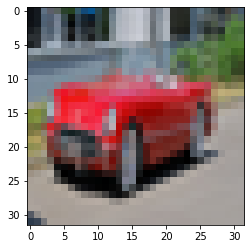

In [12]:
plot(ground_truth);
print([validloader.dataset.classes[l] for l in labels]);

In [13]:
import time
from torch.nn.modules.utils import _pair, _quadruple

DEFAULT_CONFIG = dict(signed=False,
                    boxed=True,
                    cost_fn='sim',
                    indices='def',
                    weights='equal',
                    lr=0.1,
                    optim='adam',
                    restarts=1,
                    max_iterations=4800,
                    total_variation=1e-1,
                    init='randn',
                    filter='none',
                    lr_decay=True,
                    scoring_choice='loss')

def _validate_config(config):
    for key in DEFAULT_CONFIG.keys():
        if config.get(key) is None:
            config[key] = DEFAULT_CONFIG[key]
    for key in config.keys():
        if DEFAULT_CONFIG.get(key) is None:
            raise ValueError(f'Deprecated key in config dict: {key}!')
    return config

class GradientReconstructor():
    """Instantiate a reconstruction algorithm."""

    def __init__(self, model, mean_std=(0.0, 1.0), config=DEFAULT_CONFIG, num_images=1):
        """Initialize with algorithm setup."""
        self.config = _validate_config(config)
        self.model = model
        self.setup = dict(device=next(model.parameters()).device, dtype=next(model.parameters()).dtype)

        self.mean_std = mean_std
        self.num_images = num_images

        if self.config['scoring_choice'] == 'inception':
            self.inception = InceptionScore(batch_size=1, setup=self.setup)

        self.loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
        self.iDLG = True

    def reconstruct(self, input_data, labels, img_shape=(3, 32, 32), dryrun=False, eval=True, tol=None):
        """Reconstruct image from gradient."""
        start_time = time.time()
        if eval:
            self.model.eval()

        stats = defaultdict(list)
        x = self._init_images(img_shape)
        scores = torch.zeros(self.config['restarts'])

        if labels is None:
            if self.num_images == 1 and self.iDLG:
                # iDLG trick:
                last_weight_min = torch.argmin(torch.sum(input_data[-2], dim=-1), dim=-1)
                labels = last_weight_min.detach().reshape((1,)).requires_grad_(False)
                self.reconstruct_label = False
            else:
                # DLG label recovery
                # However this also improves conditioning for some LBFGS cases
                self.reconstruct_label = True

                def loss_fn(pred, labels):
                    labels = torch.nn.functional.softmax(labels, dim=-1)
                    return torch.mean(torch.sum(- labels * torch.nn.functional.log_softmax(pred, dim=-1), 1))
                self.loss_fn = loss_fn
        else:
            assert labels.shape[0] == self.num_images
            self.reconstruct_label = False

        try:
            for trial in range(self.config['restarts']):
                x_trial, labels = self._run_trial(x[trial], input_data, labels, dryrun=dryrun)
                # Finalize
                scores[trial] = self._score_trial(x_trial, input_data, labels)
                x[trial] = x_trial
                if tol is not None and scores[trial] <= tol:
                    break
                if dryrun:
                    break
        except KeyboardInterrupt:
            print('Trial procedure manually interruped.')
            pass

        # Choose optimal result:
        if self.config['scoring_choice'] in ['pixelmean', 'pixelmedian']:
            x_optimal, stats = self._average_trials(x, labels, input_data, stats)
        else:
            print('Choosing optimal result ...')
            scores = scores[torch.isfinite(scores)]  # guard against NaN/-Inf scores?
            optimal_index = torch.argmin(scores)
            print(f'Optimal result score: {scores[optimal_index]:2.4f}')
            stats['opt'] = scores[optimal_index].item()
            x_optimal = x[optimal_index]

        print(f'Total time: {time.time()-start_time}.')
        return x_optimal.detach(), stats

    def _init_images(self, img_shape):
        if self.config['init'] == 'randn':
            return torch.randn((self.config['restarts'], self.num_images, *img_shape), **self.setup)
        elif self.config['init'] == 'rand':
            return (torch.rand((self.config['restarts'], self.num_images, *img_shape), **self.setup) - 0.5) * 2
        elif self.config['init'] == 'zeros':
            return torch.zeros((self.config['restarts'], self.num_images, *img_shape), **self.setup)
        else:
            raise ValueError()

    def _run_trial(self, x_trial, input_data, labels, dryrun=False):
        x_trial.requires_grad = True
        if self.reconstruct_label:
            output_test = self.model(x_trial)
            labels = torch.randn(output_test.shape[1]).to(**self.setup).requires_grad_(True)

            if self.config['optim'] == 'adam':
                optimizer = torch.optim.Adam([x_trial, labels], lr=self.config['lr'])
            elif self.config['optim'] == 'sgd':  # actually gd
                optimizer = torch.optim.SGD([x_trial, labels], lr=0.01, momentum=0.9, nesterov=True)
            elif self.config['optim'] == 'LBFGS':
                optimizer = torch.optim.LBFGS([x_trial, labels])
            else:
                raise ValueError()
        else:
            if self.config['optim'] == 'adam':
                optimizer = torch.optim.Adam([x_trial], lr=self.config['lr'])
            elif self.config['optim'] == 'sgd':  # actually gd
                optimizer = torch.optim.SGD([x_trial], lr=0.01, momentum=0.9, nesterov=True)
            elif self.config['optim'] == 'LBFGS':
                optimizer = torch.optim.LBFGS([x_trial])
            else:
                raise ValueError()

        max_iterations = self.config['max_iterations']
        dm, ds = self.mean_std
        if self.config['lr_decay']:
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                             milestones=[max_iterations // 2.667, max_iterations // 1.6,
                                                                        max_iterations // 1.142], gamma=0.1)   # 3/8 5/8 7/8
        try:
            for iteration in range(max_iterations):
                closure = self._gradient_closure(optimizer, x_trial, input_data, labels)
                rec_loss = optimizer.step(closure)
                if self.config['lr_decay']:
                    scheduler.step()

                with torch.no_grad():
                    # Project into image space
                    if self.config['boxed']:
                        x_trial.data = torch.max(torch.min(x_trial, (1 - dm) / ds), -dm / ds)

                    if (iteration + 1 == max_iterations) or iteration % 500 == 0:
                        print(f'It: {iteration}. Rec. loss: {rec_loss.item():2.4f}.')

                    if (iteration + 1) % 500 == 0:
                        if self.config['filter'] == 'none':
                            pass
                        elif self.config['filter'] == 'median':
                            x_trial.data = MedianPool2d(kernel_size=3, stride=1, padding=1, same=False)(x_trial)
                        else:
                            raise ValueError()

                if dryrun:
                    break
        except KeyboardInterrupt:
            print(f'Recovery interrupted manually in iteration {iteration}!')
            pass
        return x_trial.detach(), labels

    def _gradient_closure(self, optimizer, x_trial, input_gradient, label):

        def closure():
            optimizer.zero_grad()
            self.model.zero_grad()
            loss = self.loss_fn(self.model(x_trial), label)
            gradient = torch.autograd.grad(loss, self.model.parameters(), create_graph=True)
            rec_loss = reconstruction_costs([gradient], input_gradient,
                                            cost_fn=self.config['cost_fn'], indices=self.config['indices'],
                                            weights=self.config['weights'])

            if self.config['total_variation'] > 0:
                rec_loss += self.config['total_variation'] * TV(x_trial)
            rec_loss.backward()
            if self.config['signed']:
                x_trial.grad.sign_()
            return rec_loss
        return closure

    def _score_trial(self, x_trial, input_gradient, label):
        if self.config['scoring_choice'] == 'loss':
            self.model.zero_grad()
            x_trial.grad = None
            loss = self.loss_fn(self.model(x_trial), label)
            gradient = torch.autograd.grad(loss, self.model.parameters(), create_graph=False)
            return reconstruction_costs([gradient], input_gradient,
                                        cost_fn=self.config['cost_fn'], indices=self.config['indices'],
                                        weights=self.config['weights'])
        elif self.config['scoring_choice'] == 'tv':
            return TV(x_trial)
        elif self.config['scoring_choice'] == 'inception':
            # We do not care about diversity here!
            return self.inception(x_trial)
        elif self.config['scoring_choice'] in ['pixelmean', 'pixelmedian']:
            return 0.0
        else:
            raise ValueError()

    def _average_trials(self, x, labels, input_data, stats):
        print(f'Computing a combined result via {self.config["scoring_choice"]} ...')
        if self.config['scoring_choice'] == 'pixelmedian':
            x_optimal, _ = x.median(dim=0, keepdims=False)
        elif self.config['scoring_choice'] == 'pixelmean':
            x_optimal = x.mean(dim=0, keepdims=False)

        self.model.zero_grad()
        if self.reconstruct_label:
            labels = self.model(x_optimal).softmax(dim=1)
        loss = self.loss_fn(self.model(x_optimal), labels)
        gradient = torch.autograd.grad(loss, self.model.parameters(), create_graph=False)
        stats['opt'] = reconstruction_costs([gradient], input_data,
                                            cost_fn=self.config['cost_fn'],
                                            indices=self.config['indices'],
                                            weights=self.config['weights'])
        print(f'Optimal result score: {stats["opt"]:2.4f}')
        return x_optimal, stats

class InceptionScore(torch.nn.Module):
    """Class that manages and returns the inception score of images."""

    def __init__(self, batch_size=32, setup=dict(device=torch.device('cpu'), dtype=torch.float)):
        """Initialize with setup and target inception batch size."""
        super().__init__()
        self.preprocessing = torch.nn.Upsample(size=(299, 299), mode='bilinear', align_corners=False)
        self.model = torchvision.models.inception_v3(pretrained=True).to(**setup)
        self.model.eval()
        self.batch_size = batch_size

    def forward(self, image_batch):
        """Image batch should have dimensions BCHW and should be normalized.

        B should be divisible by self.batch_size.
        """
        B, C, H, W = image_batch.shape
        batches = B // self.batch_size
        scores = []
        for batch in range(batches):
            input = self.preprocessing(image_batch[batch * self.batch_size: (batch + 1) * self.batch_size])
            scores.append(self.model(input))
        prob_yx = torch.nn.functional.softmax(torch.cat(scores, 0), dim=1)
        entropy = torch.where(prob_yx > 0, -prob_yx * prob_yx.log(), torch.zeros_like(prob_yx))
        return entropy.sum()

def reconstruction_costs(gradients, input_gradient, cost_fn='l2', indices='def', weights='equal'):
    """Input gradient is given data."""
    if isinstance(indices, list):
        pass
    elif indices == 'def':
        indices = torch.arange(len(input_gradient))
    elif indices == 'batch':
        indices = torch.randperm(len(input_gradient))[:8]
    elif indices == 'topk-1':
        _, indices = torch.topk(torch.stack([p.norm() for p in input_gradient], dim=0), 4)
    elif indices == 'top10':
        _, indices = torch.topk(torch.stack([p.norm() for p in input_gradient], dim=0), 10)
    elif indices == 'top50':
        _, indices = torch.topk(torch.stack([p.norm() for p in input_gradient], dim=0), 50)
    elif indices in ['first', 'first4']:
        indices = torch.arange(0, 4)
    elif indices == 'first5':
        indices = torch.arange(0, 5)
    elif indices == 'first10':
        indices = torch.arange(0, 10)
    elif indices == 'first50':
        indices = torch.arange(0, 50)
    elif indices == 'last5':
        indices = torch.arange(len(input_gradient))[-5:]
    elif indices == 'last10':
        indices = torch.arange(len(input_gradient))[-10:]
    elif indices == 'last50':
        indices = torch.arange(len(input_gradient))[-50:]
    else:
        raise ValueError()

    ex = input_gradient[0]
    if weights == 'linear':
        weights = torch.arange(len(input_gradient), 0, -1, dtype=ex.dtype, device=ex.device) / len(input_gradient)
    elif weights == 'exp':
        weights = torch.arange(len(input_gradient), 0, -1, dtype=ex.dtype, device=ex.device)
        weights = weights.softmax(dim=0)
        weights = weights / weights[0]
    else:
        weights = input_gradient[0].new_ones(len(input_gradient))

    total_costs = 0
    for trial_gradient in gradients:
        pnorm = [0, 0]
        costs = 0
        if indices == 'topk-2':
            _, indices = torch.topk(torch.stack([p.norm().detach() for p in trial_gradient], dim=0), 4)
        for i in indices:
            if cost_fn == 'l2':
                costs += ((trial_gradient[i] - input_gradient[i]).pow(2)).sum() * weights[i]
            elif cost_fn == 'l1':
                costs += ((trial_gradient[i] - input_gradient[i]).abs()).sum() * weights[i]
            elif cost_fn == 'max':
                costs += ((trial_gradient[i] - input_gradient[i]).abs()).max() * weights[i]
            elif cost_fn == 'sim':
                costs -= (trial_gradient[i] * input_gradient[i]).sum() * weights[i]
                pnorm[0] += trial_gradient[i].pow(2).sum() * weights[i]
                pnorm[1] += input_gradient[i].pow(2).sum() * weights[i]
            elif cost_fn == 'simlocal':
                costs += 1 - torch.nn.functional.cosine_similarity(trial_gradient[i].flatten(),
                                                                input_gradient[i].flatten(),
                                                                   0, 1e-10) * weights[i]
        if cost_fn == 'sim':
            costs = 1 + costs / pnorm[0].sqrt() / pnorm[1].sqrt()

        # Accumulate final costs
        total_costs += costs
    return total_costs / len(gradients)

class MedianPool2d(nn.Module):
    """Median pool (usable as median filter when stride=1) module.

    Args:
        kernel_size: size of pooling kernel, int or 2-tuple
        stride: pool stride, int or 2-tuple
        padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
        same: override padding and enforce same padding, boolean
    """

    def __init__(self, kernel_size=3, stride=1, padding=0, same=True):
        """Initialize with kernel_size, stride, padding."""
        super().__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding

    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd,
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

def TV(x):
    """Anisotropic TV."""
    dx = torch.mean(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:]))
    dy = torch.mean(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]))
    return dx + dy

def psnr(img_batch, ref_batch, batched=False, factor=1.0):
    """Standard PSNR."""
    def get_psnr(img_in, img_ref):
        mse = ((img_in - img_ref)**2).mean()
        if mse > 0 and torch.isfinite(mse):
            return (10 * torch.log10(factor**2 / mse))
        elif not torch.isfinite(mse):
            return img_batch.new_tensor(float('nan'))
        else:
            return img_batch.new_tensor(float('inf'))

    if batched:
        psnr = get_psnr(img_batch.detach(), ref_batch)
    else:
        [B, C, m, n] = img_batch.shape
        psnrs = []
        for sample in range(B):
            psnrs.append(get_psnr(img_batch.detach()[sample, :, :, :], ref_batch[sample, :, :, :]))
        psnr = torch.stack(psnrs, dim=0).mean()

    return psnr.item()



It: 0. Rec. loss: 0.9697.
It: 500. Rec. loss: 0.1367.
It: 1000. Rec. loss: 0.1356.
It: 1500. Rec. loss: 0.1090.
It: 2000. Rec. loss: 0.0864.
It: 2500. Rec. loss: 0.0853.
It: 3000. Rec. loss: 0.0826.
It: 3500. Rec. loss: 0.0816.
It: 3999. Rec. loss: 0.0808.
Choosing optimal result ...
Optimal result score: 0.0807
Total time: 291.80804538726807.


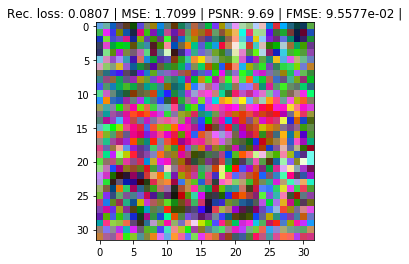

In [14]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

config = dict(signed=True,
        boxed=True,
        cost_fn='sim',
        indices='def',
        weights='equal',
        lr=0.1,
        optim='adam',
        restarts=1,
        max_iterations=4000,
        total_variation=1e-6,
        init='randn',
        filter='none',
        lr_decay=True,
        scoring_choice='loss')

rec_machine = GradientReconstructor(model, (dm, ds), config, num_images=num_images)
output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 32, 32))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = psnr(output, ground_truth, factor=1/ds)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
        f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");